In [49]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')
import time
from gpflow.utilities import print_summary

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [3]:
with open('results/2019-11-16_12-35-14_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [133]:
x_subsample = x.final.b_nn_corrected[::][10000:]
x_subsample = x_subsample.reshape(-1,1)
time_subsample = x.base_signals.t_b_nn[::][10000:]
time_subsample = time_subsample.reshape(-1,1)
mean = np.mean(x_subsample)
X, Y = time_subsample, x_subsample - mean
N = np.size(time_subsample)

In [134]:
N

29090

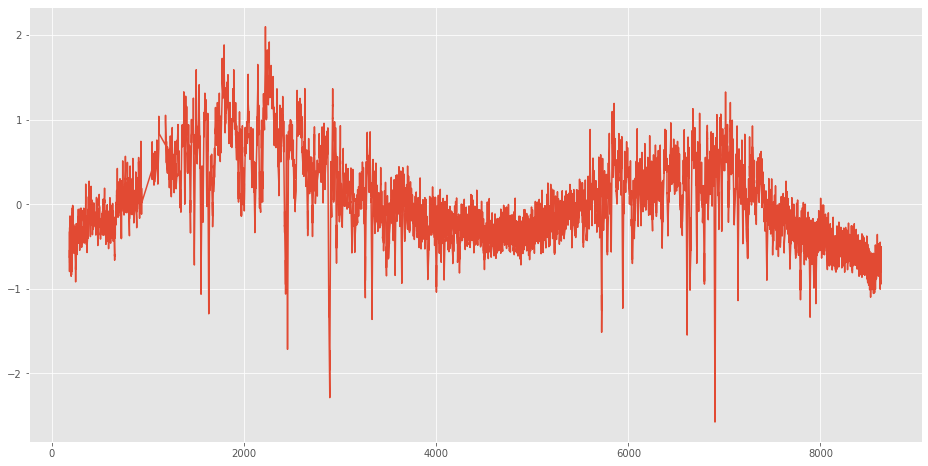

In [135]:
plt.figure(5, figsize=(16, 8))
#plt.ylim(1362.5, 1370)
plt.plot(X, Y)

In [140]:
X[::180].shape

(162, 1)

In [141]:
#M = 200  # Number of inducing locations

kernel = gpflow.kernels.Sum([gpflow.kernels.Matern32(),gpflow.kernels.White()])
Z = X[::180].copy()  # Initialise inducing locations
M = np.size(Z)
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
m.kernel.kernels[0].lengthscale.assign(427)
print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ----------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  1.0
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  427.0
SVGP.kernel.kernels[1].variance     Parameter  Softplus        True         ()             float64  1.0
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  1.0
SVGP.inducing_variable.Z            Parameter                  True         (162, 1)       float64  [[182.553...
SVGP.q_mu                           Parameter                  True         (162, 1)       float64  [[0....
SVGP.q_sqrt                         Parameter  FillTriangular  True         (1, 162, 162)  float64  [[[1., 0., 0....


In [142]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [143]:
%%timeit
log_likelihood(X, Y)

254 ms ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N)

train_it = iter(train_dataset.batch(minibatch_size))

ground_truth = m.log_likelihood(X, Y).numpy()

In [145]:
%%timeit
log_likelihood(*next(train_it))

2.37 ms ± 50.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
evals = [log_likelihood(*minibatch).numpy()
         for minibatch in itertools.islice(train_it, 100)]

Discrepancy between ground truth and minibatch estimate: -51.41550790666952


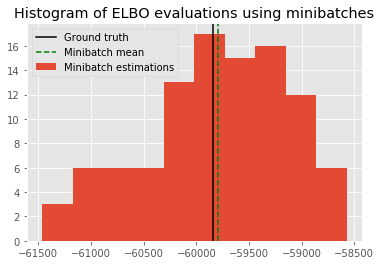

In [147]:
plt.hist(evals, label='Minibatch estimations')
plt.axvline(ground_truth, c='k', label='Ground truth')
plt.axvline(np.mean(evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth - np.mean(evals))

In [148]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(N * mbp)
    train_it = iter(train_dataset.batch(batchsize))
    start_time = time.time()
    objs.append([log_likelihood(*minibatch)
                 for minibatch in itertools.islice(train_it, 20)])
    times.append(time.time() - start_time)

Text(0, 0.5, 'ELBO estimates')

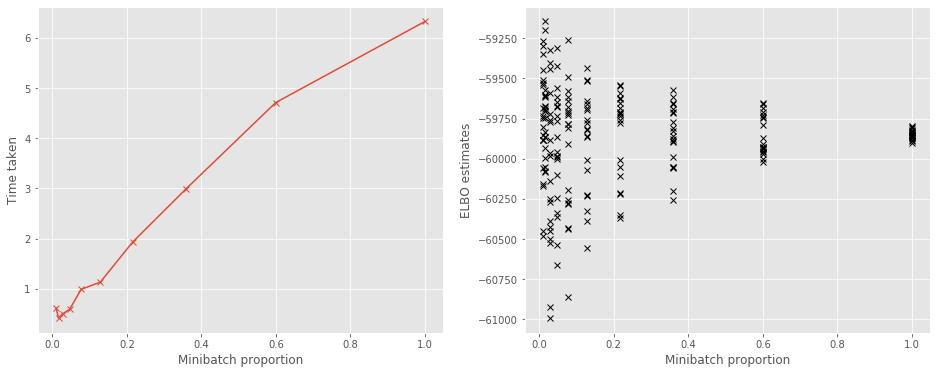

In [149]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

(162, 1)


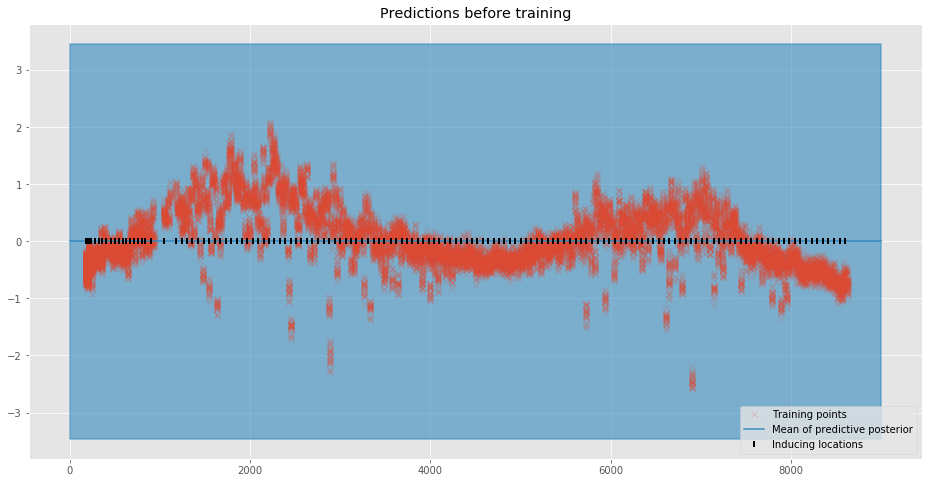

In [150]:
def plot(title=''):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    pX = np.linspace(0, 9000, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = m.inducing_variable.Z.numpy()
    print(Z.shape)
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')

plot(title="Predictions before training")

In [151]:
minibatch_size = 100

# We turn of training for inducing point locations
gpflow.utilities.set_trainable(m.inducing_variable, False)

@tf.function(autograph=False)
def optimization_step(optimizer, model: gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    """
    Utility function running the Adam optimiser
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    logf = []
    train_it = iter(train_dataset.batch(minibatch_size))
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        if step % 1000 == 0:
            print('We are on the step {}'.format(step))
        elbo = - optimization_step(adam, model, next(train_it))
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

We are on the step 0
We are on the step 1000
We are on the step 2000
We are on the step 3000
We are on the step 4000
We are on the step 5000
We are on the step 6000
We are on the step 7000
49.24721574783325


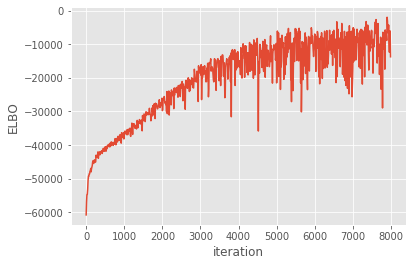

In [152]:
start = time.time()

maxiter = ci_niter(8000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');

end = time.time()
print(end - start)

(162, 1)


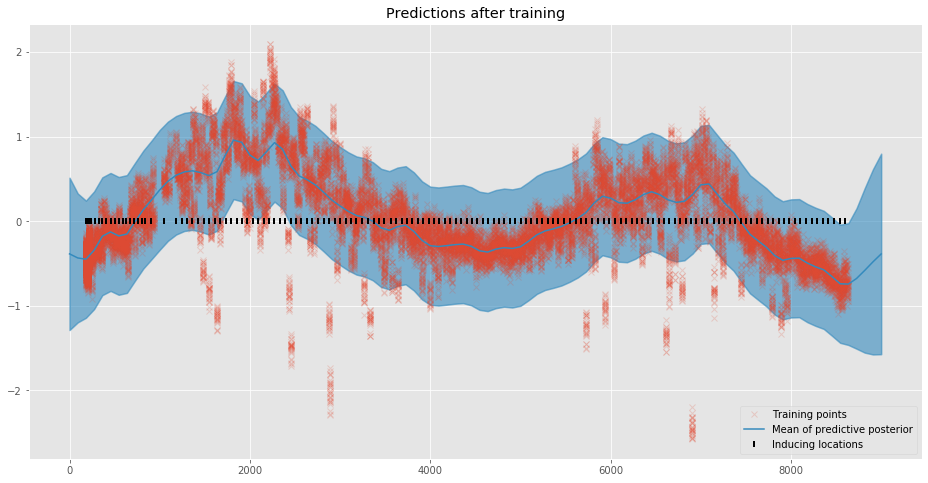

In [153]:
plot("Predictions after training")